## Analyse Exploratoire

### Import des modules

In [51]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from scipy.stats import f_oneway
from kneed import KneeLocator

In [53]:
pd.set_option('display.max_rows', 70)
pd.set_option('display.max_columns', 45)

### Analyse Exploratoire

In [56]:
building_consumption = pd.read_csv('2016_Building_Energy_Benchmarking.csv')

In [58]:
# On regarde comment un batiment est défini dans ce jeu de données 
building_consumption.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,...,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,...,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,...,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,...,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,...,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,...,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [60]:
# On regarde le nombre de valeurs manquantes par colonne ainsi que leur type 
building_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

#### TERMINER L'ANALYSE EXPLORATOIRE
#### 1. Analyse Exploratoire des Données (EDA)

##### Objectifs  
- Comprendre au mieux les données  
- Établir une première stratégie de modélisation  

---

##### Analyse de la structure des données  
- **Variable cible** : `TotalGHGEmissions` & `SiteEnergyUseWN(kBtu)` (choix lié aux conditions météo)  
- **Dimensions** : 3376 lignes × 46 colonnes (dont 1546 lignes pour bâtiments non résidentiels)  
- **Types de variables** :  
  - Qualitatives : 15  
  - Quantitatives : 30 (22 float, 8 int)  
  - Booléenne : 1  
- **Valeurs manquantes** :  
  - 5 variables avec > 80% de NaN (probablement à supprimer)  
  - 2 variables autour de 50% de NaN  
  - 20 variables sans NaN  
  - Autres variables entre 0.1% et 25% de NaN  
  - Plusieurs variables partagent le même taux de NaN, suggérant un lien  

---

##### Analyse descriptive et relationnelle  
- **Distribution des cibles** :  
  - `TotalGHGEmissions` suit une distribution proche de la normale (après log-transformation), concentrée entre 0 et 100  
  - `SiteEnergyUseWN(kBtu)` a une distribution similaire, légèrement plus concentrée  

- **Variables quantitatives** :  
  - Certaines paires ont des distributions très similaires (probablement mêmes informations avec unités différentes)  
  - Majorité des bâtiments construits avant 1930 ou après 1960, peu entre 1930 et 1945 (impact historique probable)  

- **Variables qualitatives** :  
  - Nombre élevé de catégories, rendant leur exploitation plus complexe  

- **Relations variables / cibles** :  
  - Corrélation positive forte entre consommation énergétique et émissions de gaz à effet de serre  
  - Influence complexe de l’année de construction : les bâtiments plus récents semblent consommer plus, contrairement aux attentes  
  - Secteurs Santé et Recherche consomment et émettent plus que Industrie et Logistique  

- **Corrélations clés** :  
  - Variables fortement corrélées aux cibles :  
    `NaturalGas(therms)`, `NaturalGas(kbtu)`, `Electricity(kwh)`, `Electricity(kbtu)`, `SteamUse(kbtu)`, `SiteEnergyUse(kbtu)`, `PropertyGFABuilding`, `PropertyGFATotal`  
  - Variables redondantes à supprimer (forte corrélation mutuelle) :  
    - `PropertyGFATotal` ⇔ `PropertyGFABuilding`  
    - `SiteEUI` ⇔ `SourceEUI`, `SourceEUIWN`, `SiteEUIWN`  
    - `SiteEnergyUse` ⇔ `SiteEnergyUseWN`  
    - `Electricity(kBtu)` ⇔ `Electricity(kWh)`  
    - `NaturalGas(therms)` ⇔ `NaturalGas(kbtu)`  

- **Attention au data leakage** :  
  - Variables dérivées de la consommation énergétique ne doivent pas être utilisées comme prédicteurs afin d’éviter la fuite d’information (data leakage).  

---

##### Impact du type de bâtiment  
- Les cibles (`SiteEnergyUseWN`, `TotalGHGEmissions`) varient fortement selon le type de bâtiment  
- Nombre d’étages, nombre de bâtiments et surface de parking sont également influencés par le type de bâtiment  
- L’année de construction a une influence plus faible mais significative (p-value = 0.011)  


A réaliser : 
- Une analyse descriptive des données, y compris une explication du sens des colonnes gardées, des arguments derrière la suppression de lignes ou de colonnes, des statistiques descriptives et des visualisations pertinentes.

Qelques pistes d'analyse : 
* Identifier les colonnes avec une majorité de valeurs manquantes ou constantes en utilisant la méthode value_counts() de Pandas
* Mettre en evidence les différences entre les immeubles mono et multi-usages
* Utiliser des pairplots et des boxplots pour faire ressortir les outliers ou des batiments avec des valeurs peu cohérentes d'un point de vue métier 

In [64]:
building_consumption.shape

(3376, 46)

<Axes: >

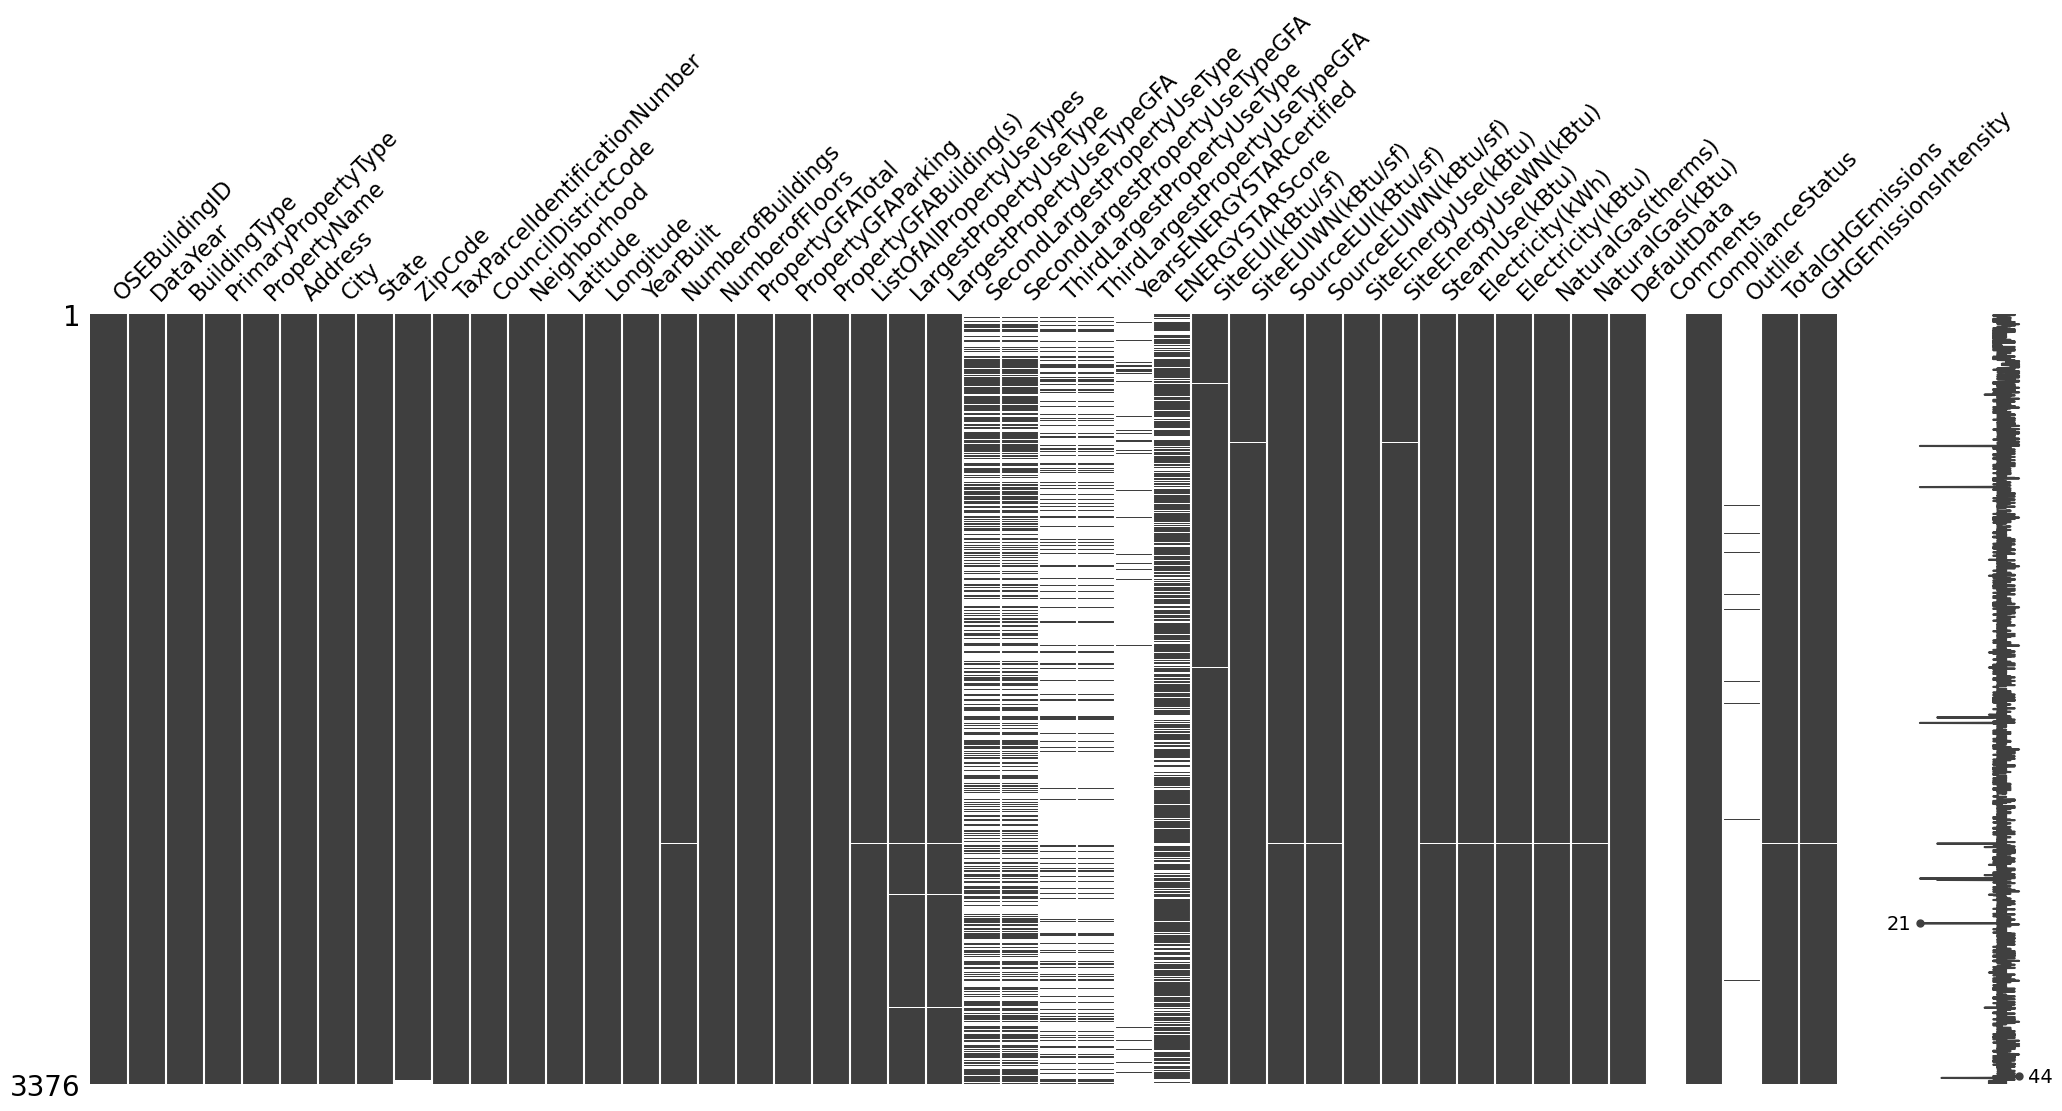

In [66]:
msno.matrix(building_consumption)

In [68]:
# Vérifion nos valeurs manquantes
(building_consumption.isnull().mean()*100).sort_values(ascending = False)

Comments                           100.000000
Outlier                             99.052133
YearsENERGYSTARCertified            96.475118
ThirdLargestPropertyUseType         82.345972
ThirdLargestPropertyUseTypeGFA      82.345972
SecondLargestPropertyUseType        50.266588
SecondLargestPropertyUseTypeGFA     50.266588
ENERGYSTARScore                     24.970379
LargestPropertyUseTypeGFA            0.592417
LargestPropertyUseType               0.592417
ZipCode                              0.473934
ListOfAllPropertyUseTypes            0.266588
SourceEUIWN(kBtu/sf)                 0.266588
SourceEUI(kBtu/sf)                   0.266588
Electricity(kWh)                     0.266588
Electricity(kBtu)                    0.266588
NaturalGas(therms)                   0.266588
NaturalGas(kBtu)                     0.266588
TotalGHGEmissions                    0.266588
SteamUse(kBtu)                       0.266588
GHGEmissionsIntensity                0.266588
NumberofBuildings                 

**Identification des doublons**

- **OSEBuildingID** : 0 doublon (identifiant unique pour chaque propriété)  
- **PropertyName** : 14 doublons détectés, mais après vérification, ce ne sont pas de vrais doublons  
- **Longitude & Latitude** : 93 doublons détectés, mais ce sont des cas où plusieurs appartements/propriétés partagent le même bâtiment (pas de doublons réels)  

---

**Étude de quelques variables clés**

- **BuildingType** :  
  - `NonResidential` : 1460 occurrences  
  - `Nonresidential COS` : 85  
  - `Nonresidential WA` : 1  
  - Autres (peu fréquents) : `Multifamily LR (1-4)`, `Multifamily MR (5-9)`, `Multifamily HR (10+)`, `SPS-District K-12`, `Campus`  
  - *Note* : Cette variable sera supprimée après extraction des bonnes données car elle n’apporte plus de valeur  

- **DefaultData** :  
  - `False` : 3254  
  - `True` : 113 (à vérifier avec la source, raison de création inconnue)   

---

In [71]:
# Je prefère utilisé une copie de mon dataframe a partir de ce stade
df_seattle = building_consumption.copy()
df_seattle['BuildingType'].value_counts()

BuildingType
NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64

In [73]:
# Comme le projet parle de modelisation des bâtiments non destinés à l’habitation
df_seattle = df_seattle.loc[df_seattle['BuildingType'].str.startswith(('NonResidential', 'Nonresidential'))  , :]
df_seattle.shape

(1546, 46)

In [75]:
def fill_rate(df):
    """Calcule, pour chaque colonne de df, le taux de remplissage (en pourcentage)
    et le nombre de valeurs manquantes."""
    # Pourcentage de valeurs non manquantes
    taux = df.notna().mean() * 100
    # Nombre de valeurs manquantes
    n_manquants = df.isna().sum()

    # Assemblage du résultat
    result = (
        pd.DataFrame({
            "% de remplissage": taux.round(1),
            "Nombre de NaN": n_manquants
        })
        .sort_values(by="% de remplissage", ascending=False)
    )

    return result


fill_rate(df_seattle)

,% de remplissage,Nombre de NaN
OSEBuildingID,100.0,0
Neighborhood,100.0,0
DataYear,100.0,0
DefaultData,100.0,0
PropertyGFABuilding(s),100.0,0
PropertyGFAParking,100.0,0
PropertyGFATotal,100.0,0
NumberofFloors,100.0,0
ComplianceStatus,100.0,0
Longitude,100.0,0


In [77]:
# Supprimons les données considérées comme outlier (grace a cette colonne qui a deux modalités remplie = True ou Nan = False)
print(df_seattle['Outlier'].value_counts())
print(df_seattle['DefaultData'].value_counts())

Outlier
Low outlier     14
High outlier     2
Name: count, dtype: int64
DefaultData
False    1533
True       13
Name: count, dtype: int64


In [79]:
# Supprimons la colonne après car elle n'apporte plus de valeur
df_seattle = (
    df_seattle
    [df_seattle['Outlier'].isna()]   # on filtre
    .drop('Outlier', axis=1)        # on supprime la colonne
)


df_seattle = (
    df_seattle
    [df_seattle['DefaultData']==False]   # on filtre sur faux
    .drop('DefaultData', axis=1)        # on supprime la colonne, nous pourvons ajouter Comments (100% de NaN)
)

df_seattle.drop(columns = 'Comments', inplace= True)
df_seattle.shape

(1518, 43)

In [81]:
# Objectif : filtrer les incohérences flagrantes

# Filtre 1 : cohérence des surfaces (GFA = Gross Floor Area)
# Vérifions que la somme des surfaces des 3 plus grands usages ne dépasse pas la surface totale du bâtiment
df_seattle = df_seattle.loc[
    ~(
        df_seattle['PropertyGFATotal'] <
        (
            df_seattle['LargestPropertyUseTypeGFA'] +
            df_seattle['SecondLargestPropertyUseTypeGFA'] +
            df_seattle['ThirdLargestPropertyUseTypeGFA']
        )
    )
]

# Filtre 2 : cohérence des consommations d’énergie
# Vérifions que la somme des consommations par type d’énergie ne dépasse pas la consommation totale
df_seattle = df_seattle.loc[
    ~(
        df_seattle['SiteEnergyUse(kBtu)'] <
        (
            df_seattle['SteamUse(kBtu)'] +
            df_seattle['Electricity(kBtu)'] +
            df_seattle['NaturalGas(kBtu)']
        )
    )
]

# Affichage du nombre de lignes après filtrage
print(f"Nombre de lignes après filtrage des incoherences: {df_seattle.shape[0]}")

# Supprimons les lignes (propriété) n’ayant pas de valeur cible SiteEnergyUseWN(kBtu) et TotalGHGEmissions
df_seattle = df_seattle.dropna(subset=['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)'])
print(f"Nombre de lignes après suprresion des valeur NaN lié au cibles: {df_seattle.shape[0]}")

Nombre de lignes après filtrage des incoherences: 1122
Nombre de lignes après suprresion des valeur NaN lié au cibles: 1120


In [83]:
# Faissons une petite description statisque
df_seattle.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,1120.000000,1120.0,1110.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1.120000e+03,1120.000000,1.120000e+03,1.117000e+03,591.000000,193.000000,736.000000,1119.000000,1120.000000,1120.000000,1120.000000,1.120000e+03,1.120000e+03,1.120000e+03,1.120000e+03,1.120000e+03,1.120000e+03,1.120000e+03,1120.000000,1120.000000
mean,15651.284821,2016.0,98116.081081,4.513393,47.617553,-122.333856,1963.555357,1.051786,4.458929,1.185094e+05,15467.169643,1.030422e+05,9.533404e+04,35011.248218,13657.461140,62.012228,82.529491,84.640357,203.987857,205.724375,8.534340e+06,8.611913e+06,6.174069e+05,1.760468e+06,6.006717e+06,1.860952e+04,1.860952e+06,188.366857,1.732295
std,14215.241415,0.0,18.481992,2.188564,0.046157,0.022717,32.670869,0.620614,6.789580,1.920994e+05,45989.723153,1.692231e+05,1.564336e+05,64660.714914,30468.678198,28.971083,82.314243,83.313149,208.075585,208.054307,2.055166e+07,2.070268e+07,6.178514e+06,4.125606e+06,1.407657e+07,6.060737e+04,6.060737e+06,648.822212,2.404478
min,1.000000,2016.0,98006.000000,1.000000,47.509590,-122.407650,1900.000000,0.000000,0.000000,1.168500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,-0.800000,-0.020000
25%,567.500000,2016.0,98104.000000,2.000000,47.595063,-122.344048,1930.000000,1.000000,1.000000,3.098450e+04,0.000000,2.978200e+04,2.644000e+04,5240.500000,2825.000000,42.000000,38.450001,40.675000,94.174997,97.149998,1.441842e+06,1.538549e+06,0.000000e+00,2.578964e+05,8.799425e+05,0.000000e+00,0.000000e+00,23.397500,0.367500
50%,20739.000000,2016.0,98109.000000,4.000000,47.613730,-122.333210,1967.500000,1.000000,3.000000,5.340000e+04,0.000000,5.039250e+04,4.600000e+04,12379.000000,6000.000000,69.000000,57.799999,60.250000,151.199997,153.449997,3.298408e+06,3.411097e+06,0.000000e+00,6.560930e+05,2.238590e+06,4.910975e+03,4.910975e+05,58.320000,0.900000
75%,24409.000000,2016.0,98122.000000,7.000000,47.648715,-122.323125,1991.000000,1.000000,5.000000,1.147012e+05,0.000000,1.012832e+05,9.866800e+04,31547.000000,11988.000000,86.000000,92.300003,94.925001,234.274998,237.724998,8.230741e+06,8.269021e+06,0.000000e+00,1.701614e+06,5.805908e+06,1.712353e+04,1.712353e+06,162.795000,2.060000
max,50226.000000,2016.0,98199.000000,7.000000,47.733870,-122.261800,2015.000000,9.000000,99.000000,1.952220e+06,512608.000000,1.765970e+06,1.680937e+06,686750.000000,303910.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,2.930908e+08,2.966717e+08,1.349435e+08,8.046087e+07,2.745325e+08,1.381912e+06,1.381912e+08,12307.160000,25.710000


**Rémarque de quelques Anomalies dans le jeu de données**
- DataYear est identique pour toutes les lignes (2016). Cette colonne n’apporte aucune information comparative.
- NumberofBuildings a une valeur minimale à 0, or on ne peut pas avoir « zéro bâtiment » dans l’enregistrement.
- Des valeur négatif pour `Electricity(kWh)`, `Electricity(kBtu)`, `TotalGHGEmissions`, `GHGEmissionsIntensity`
- Des valeur très élévée `PropertyGFATotal` : *1.9 million ft²* , `SiteEnergyUse(kBtu)` : *293 millions kBtu*, `Electricity(kWh)` : *80 millions kWh*

In [86]:
df_seattle = df_seattle.drop(columns=['DataYear'])

# Filtrer : ne conservons que les lignes où AUCUNE de ces colonnes n’est à 0
# Conditions combinées
conds = (
    (df_seattle['Electricity(kWh)']         >= 0) &
    (df_seattle['Electricity(kBtu)']        >= 0) &
    (df_seattle['TotalGHGEmissions']        >= 0) &
    (df_seattle['GHGEmissionsIntensity']    >= 0) &
    (df_seattle['NumberofBuildings']        >= 1)
)

# Filtrage unique et création d’une copie
df_seattle = df_seattle.loc[conds]
print('Taille de notre dataframe',df_seattle.shape)
fill_rate(df_seattle)

Taille de notre dataframe (1084, 42)


,% de remplissage,Nombre de NaN
OSEBuildingID,100.0,0
SiteEnergyUseWN(kBtu),100.0,0
ListOfAllPropertyUseTypes,100.0,0
BuildingType,100.0,0
SiteEUIWN(kBtu/sf),100.0,0
SourceEUI(kBtu/sf),100.0,0
SourceEUIWN(kBtu/sf),100.0,0
SiteEnergyUse(kBtu),100.0,0
SteamUse(kBtu),100.0,0
PropertyGFAParking,100.0,0


***Suppression des variables non pertinentes***

Les colonnes suivantes ont été supprimées, car elles n’apportent pas d’information utile à l’analyse énergétique ou environnementale :
- Colonnes identifiantes ou géographiques : `Address`, `Longitude`, `Neighborhood`, etc.
- Colonnes administratives ou redondantes : `BuildingType`, `CouncilDistrictCode`, etc.
- `ComplianceStatus` ne sera pas retenue comme variable features dans cette analyse.

In [89]:
# D'après mes recherches sur le site. Voici les variables qui ne sont pas intérressante pour notre étude
var_2delete = ['OSEBuildingID', 'PropertyName', 'TaxParcelIdentificationNumber',
             'Address', 'City', 'State', 'ZipCode', 'Longitude', 'Latitude', 'Neighborhood',
              'CouncilDistrictCode', 'BuildingType', 'ComplianceStatus', 'YearsENERGYSTARCertified', 'ListOfAllPropertyUseTypes']

df_seattle = df_seattle.drop(columns= var_2delete, axis = 1)
print('Taille de notre dataframe',df_seattle.shape)
fill_rate(df_seattle)

Taille de notre dataframe (1084, 27)


,% de remplissage,Nombre de NaN
PrimaryPropertyType,100.0,0
YearBuilt,100.0,0
TotalGHGEmissions,100.0,0
NaturalGas(kBtu),100.0,0
NaturalGas(therms),100.0,0
Electricity(kBtu),100.0,0
Electricity(kWh),100.0,0
SteamUse(kBtu),100.0,0
SiteEnergyUseWN(kBtu),100.0,0
SiteEnergyUse(kBtu),100.0,0


* **ETUDE DES OUTLIERS**

In [92]:
# Une fonction qui detect nos outliers en fonction d'un seuil que nous pouvons choisir
def detect_outliers_iqr(df, columns, thresh=3):
    outlier_indices = set()
    for col in columns:
        col_data = df[col].dropna()  # Ignorer les NaN uniquement ici

        Q1 = col_data.quantile(0.25)
        Q3 = col_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - thresh * IQR
        upper_bound = Q3 + thresh * IQR

        outliers = col_data[(col_data < lower_bound) | (col_data > upper_bound)]
        print(f"{col}: {len(outliers)} outliers")
        outlier_indices.update(outliers.index)

    print(f"\nNombre total de lignes contenant au moins un outlier : {len(outlier_indices)}")
    return df.loc[list(outlier_indices)]

In [94]:
columns_to_check = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'LargestPropertyUseTypeGFA', 
                    'ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'] # Quelques variables que j'ai choisie d'étudier

outliers_df = detect_outliers_iqr(df_seattle, columns_to_check)
outliers_df.sample(1)

YearBuilt: 0 outliers
NumberofBuildings: 33 outliers
NumberofFloors: 39 outliers
LargestPropertyUseTypeGFA: 62 outliers
ENERGYSTARScore: 0 outliers
SiteEnergyUseWN(kBtu): 56 outliers
TotalGHGEmissions: 56 outliers

Nombre total de lignes contenant au moins un outlier : 138


,PrimaryPropertyType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
11,Hotel,1998,1.0,25,333176,61161,272015,Hotel,336640.0,NaN,NaN,NaN,NaN,36.0,80.0,80.400002,199.0,199.399994,26941110.0,27070114.0,5999360.5,5299838.5,18083049.0,28586.99805,2858700.0,740.97,2.22


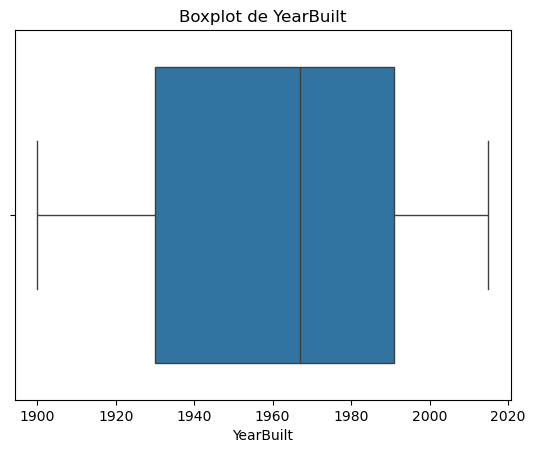

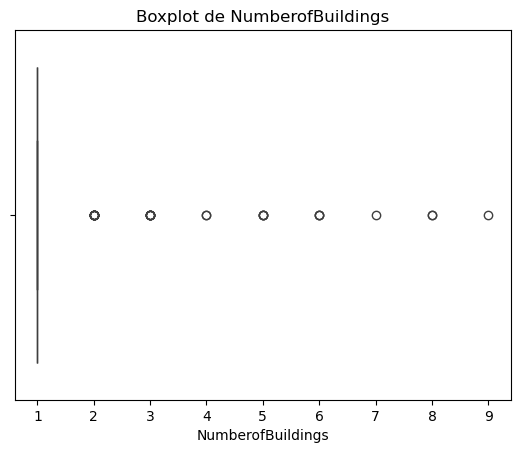

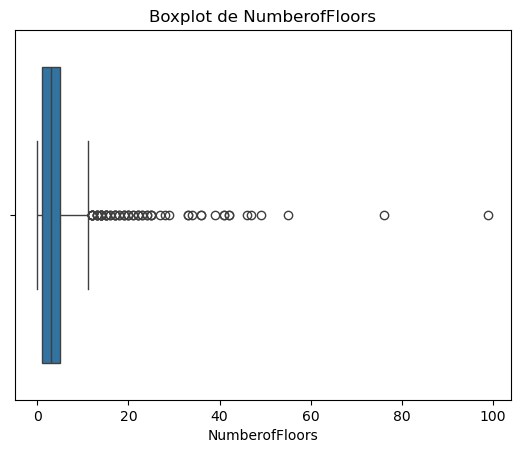

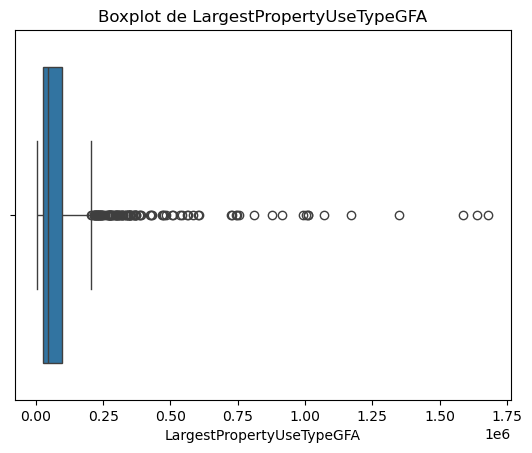

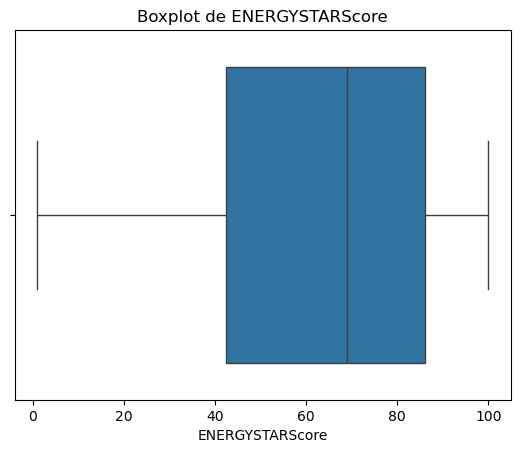

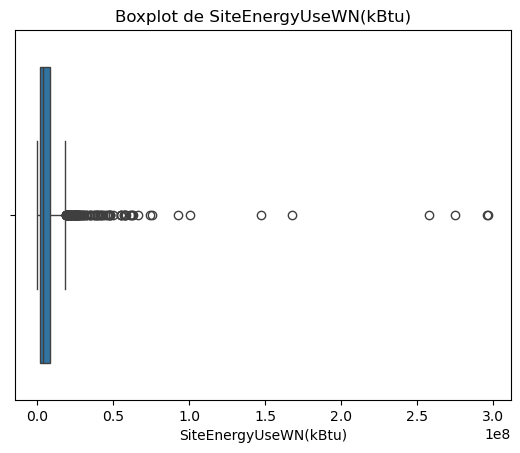

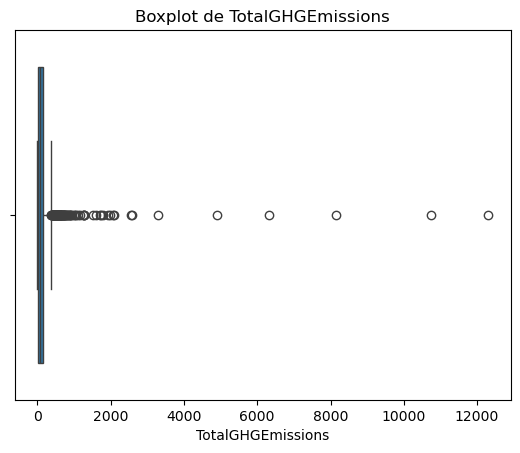

In [96]:
for col in columns_to_check:
    sns.boxplot(x=df_seattle[col])
    plt.title(f'Boxplot de {col}')
    plt.show()

* D'après mes récherches <<Le plus haut édifice de la ville de Seattle est le gratte-ciel du nom de Columbia Center. Achevé en 1985, il compte 76 étages et s'élève à 286 mètres de hauteur.>>
* Pour les variables `NumberofBuildings` et `LargestPropertyUseTypeGFA` nous allons remplacer toutes les valeurs en dehors d’un certain intervalle (par exemple 1% à 99%) par les bornes de cet intervalle. Cela limite l’effet des outliers sans les supprimer.
* pour nos cible nous allons les traiter dans le prochain notebook en utilisant une transformation logarithmique pour réduire l’effet des très gros outliers

In [99]:
# On ne garde que les bâtiments à 76 étages ou moins
df_seattle = df_seattle[df_seattle['NumberofFloors'] <= 76]

for var in ['NumberofBuildings', 'LargestPropertyUseTypeGFA']:
    # Calcul des bornes 1% et 99% pour nos variables
    lower_nb = df_seattle[var].quantile(0.01)
    upper_nb = df_seattle[var].quantile(0.99)
    df_seattle.loc[:, var] = df_seattle[var].clip(lower=lower_nb,
                                                 upper=upper_nb)

df_seattle.shape

(1083, 27)

##### ETUDES DE DISTRIBUTION DE NOS VARIABLES

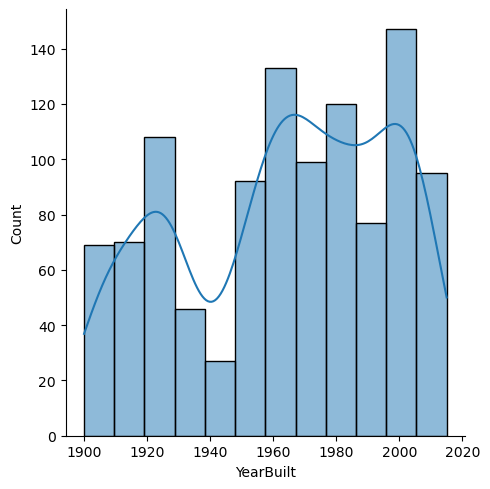

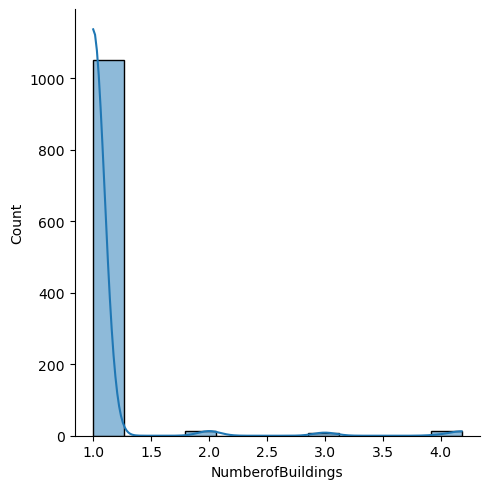

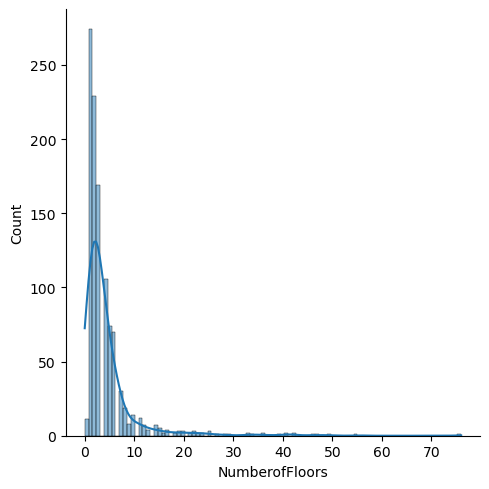

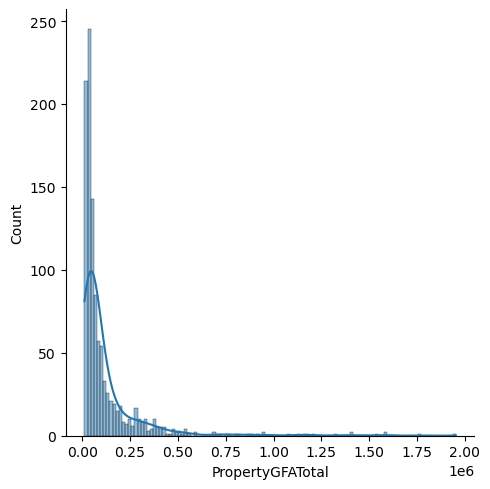

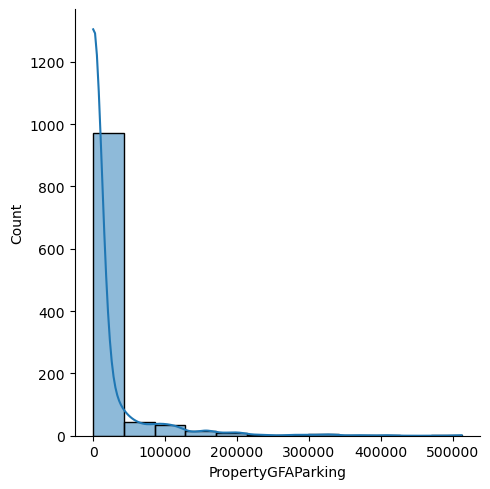

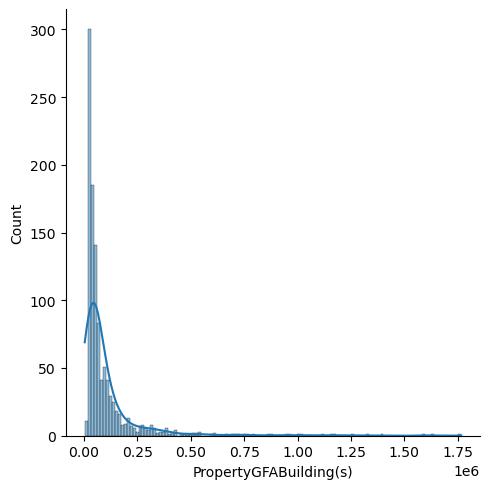

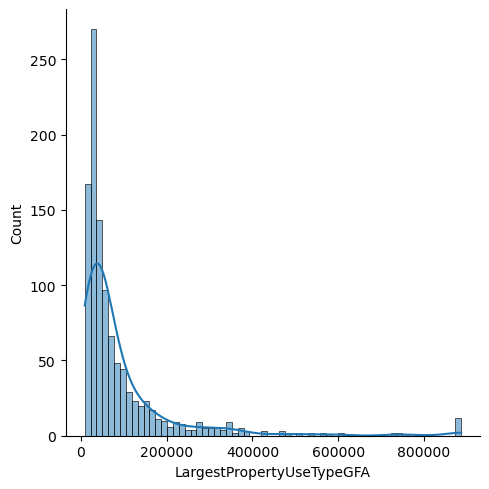

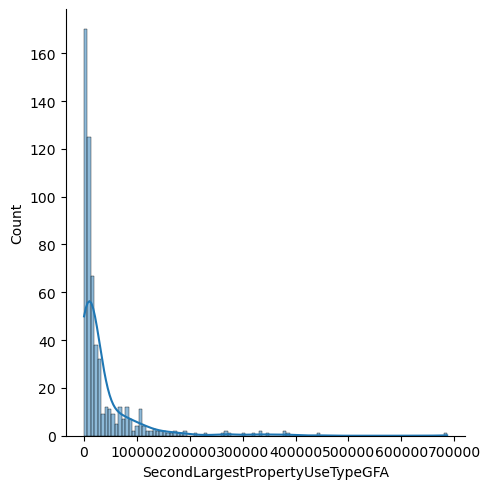

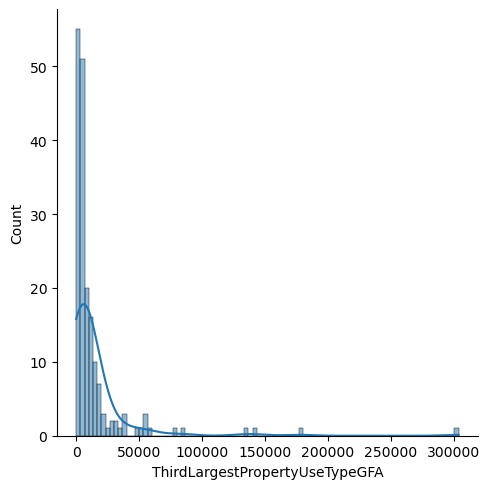

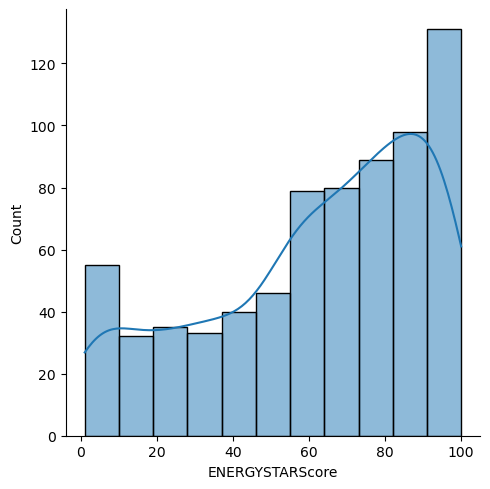

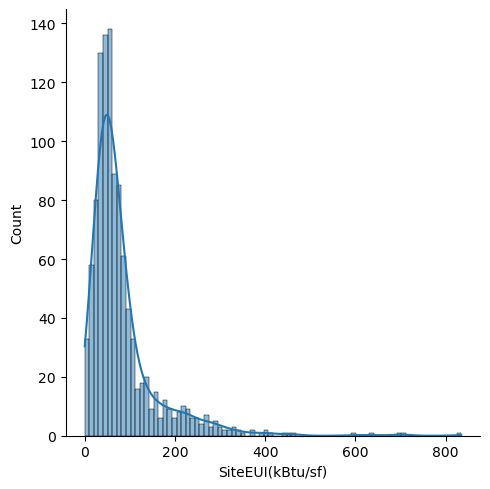

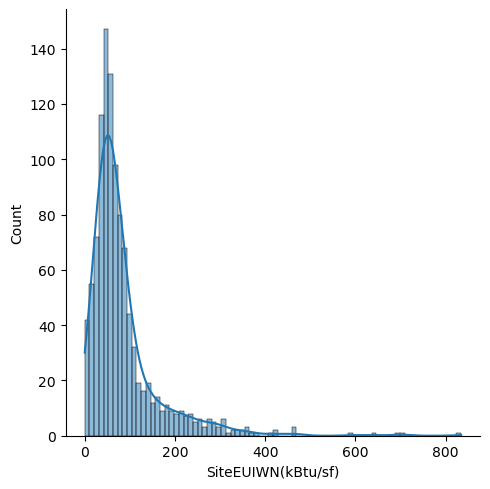

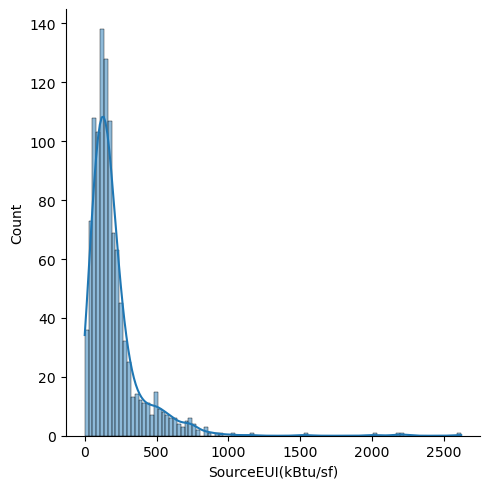

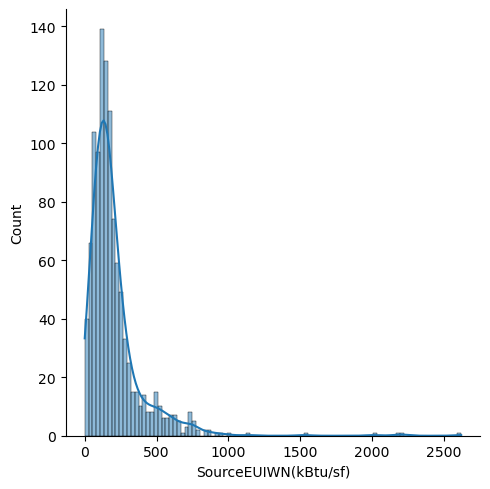

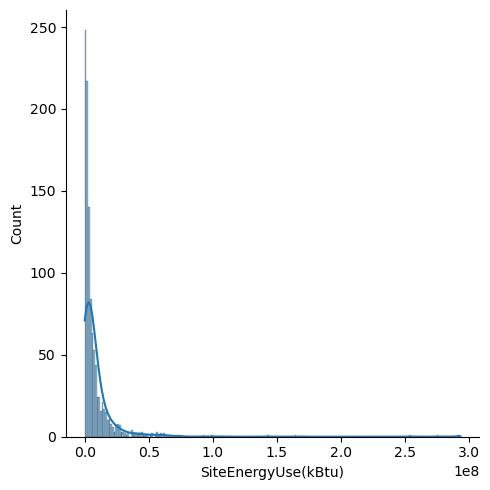

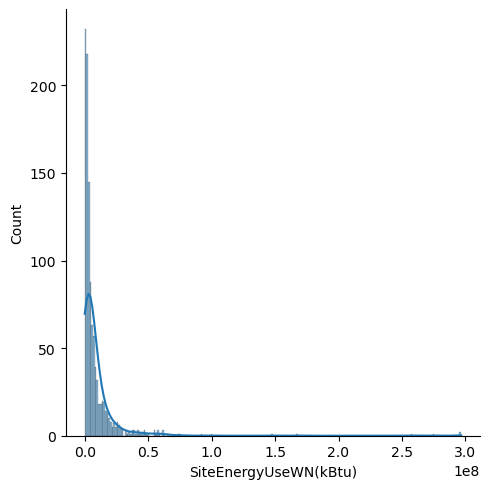

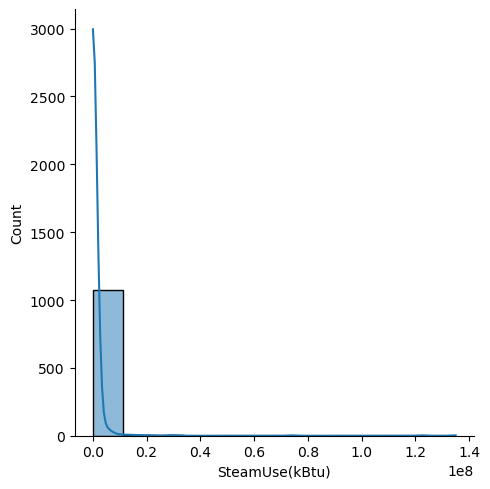

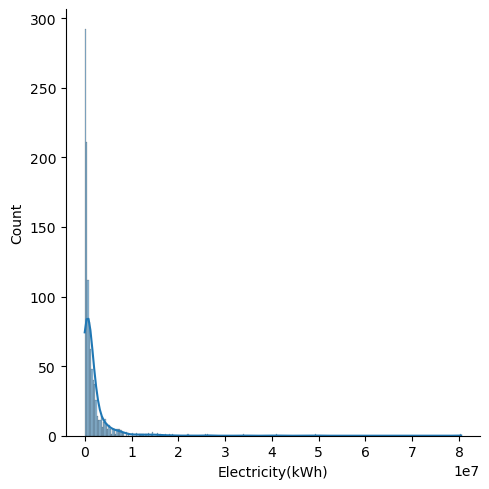

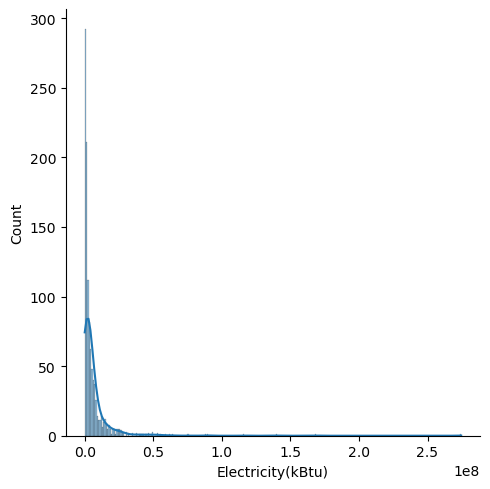

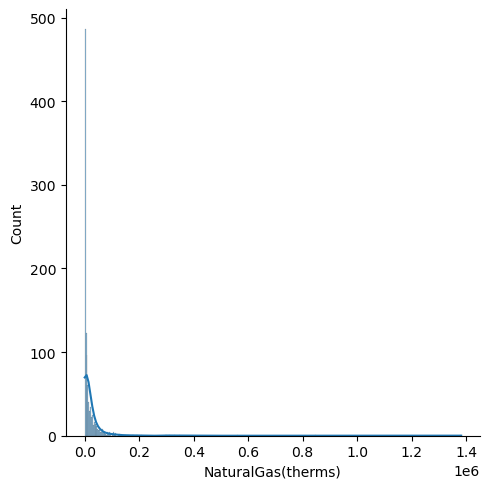

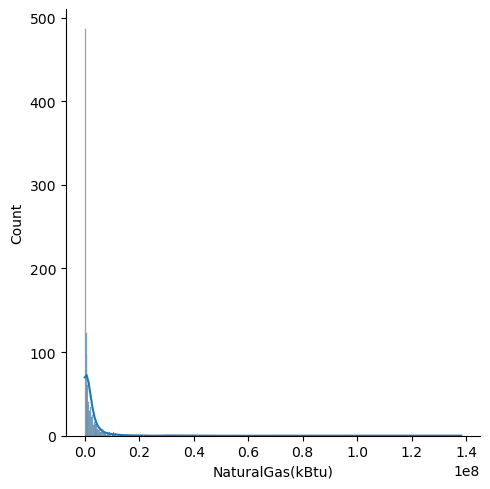

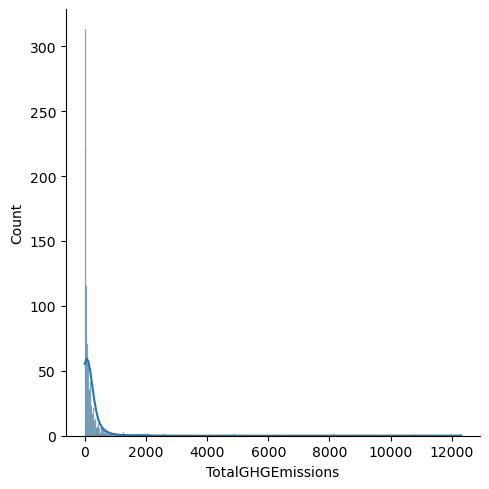

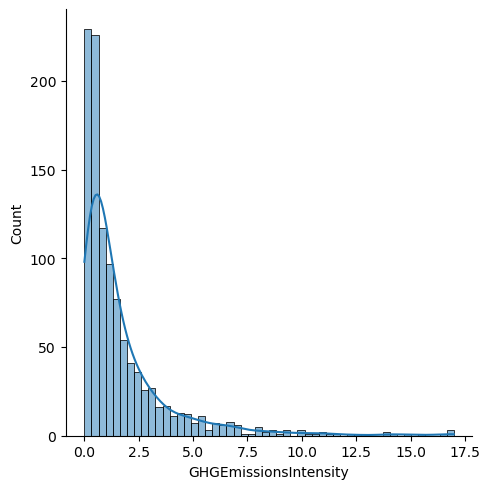

In [102]:
# Pour les variables de types numerique
for col in df_seattle.select_dtypes(include=np.number):
    sns.displot(df_seattle[col], kde=True)
    plt.show()

In [104]:
# Pour les variables de types object (Trop de catégories dans la dernière variable) --> Liste of all categoriesUse
for col in df_seattle.select_dtypes(exclude=np.number):
    print(f'Les diffirents catégories dans ma variable {col} sont :')
    print(f'{df_seattle[col].unique()}\n')
    print('='*100)
# Pour les variables de types object (Trop de catégories dans nos varia les

Les diffirents catégories dans ma variable PrimaryPropertyType sont :
['Hotel' 'Other' 'Mixed Use Property' 'University'
 'Small- and Mid-Sized Office' 'K-12 School' 'Self-Storage Facility'
 'Senior Care Community' 'Retail Store' 'Large Office' 'Hospital'
 'Residence Hall' 'Warehouse' 'Medical Office'
 'Supermarket / Grocery Store' 'Distribution Center' 'Laboratory'
 'Refrigerated Warehouse' 'Restaurant' 'Low-Rise Multifamily'
 'Worship Facility']

Les diffirents catégories dans ma variable LargestPropertyUseType sont :
['Hotel' 'Police Station' 'Other - Entertainment/Public Assembly'
 'Social/Meeting Hall' 'Courthouse' 'Other' 'College/University'
 'Automobile Dealership' 'Office' 'K-12 School' 'Self-Storage Facility'
 'Other - Mall' 'Senior Care Community' 'Medical Office' 'Retail Store'
 'Hospital (General Medical & Surgical)' 'Museum'
 'Repair Services (Vehicle, Shoe, Locksmith, etc)'
 'Residence Hall/Dormitory' 'Other/Specialty Hospital' 'Financial Office'
 'Non-Refrigerated Wareh

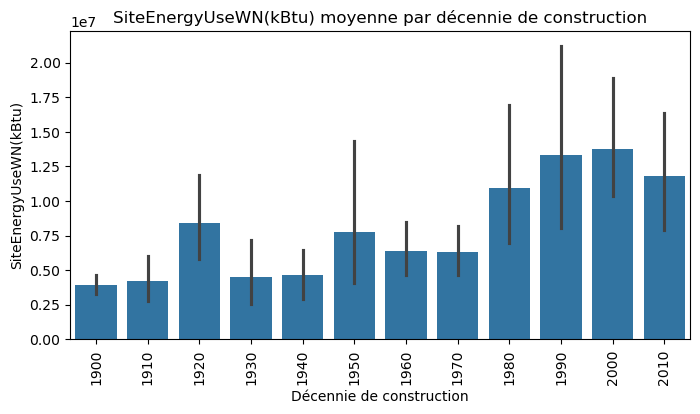

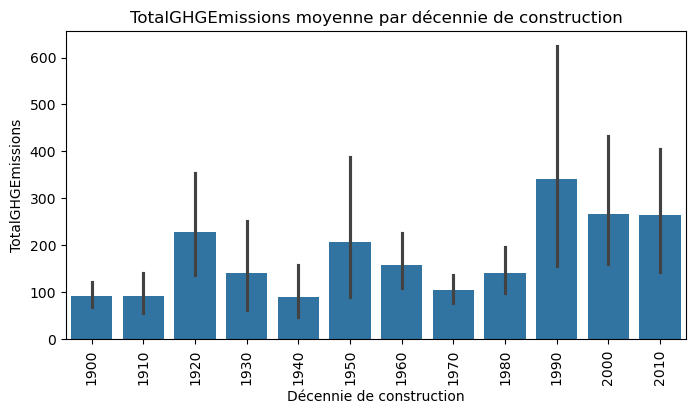

In [106]:
# Etude des consommation des batiments en fonction de leur année de construction
df_seattle['Decennie'] = (df_seattle['YearBuilt'] // 10) * 10  # Regroupe par décennie

for target in ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']:
    
    plt.figure(figsize=(8, 4))
    # sns.boxplot(x='Decennie', y='SiteEnergyUseWN(kBtu)', data=df_seattle)
    sns.barplot(x='Decennie', y=target, data=df_seattle)
    plt.xticks(rotation=90)
    plt.title(f"{target} moyenne par décennie de construction")
    plt.ylabel(target)
    plt.xlabel("Décennie de construction")
    plt.show()

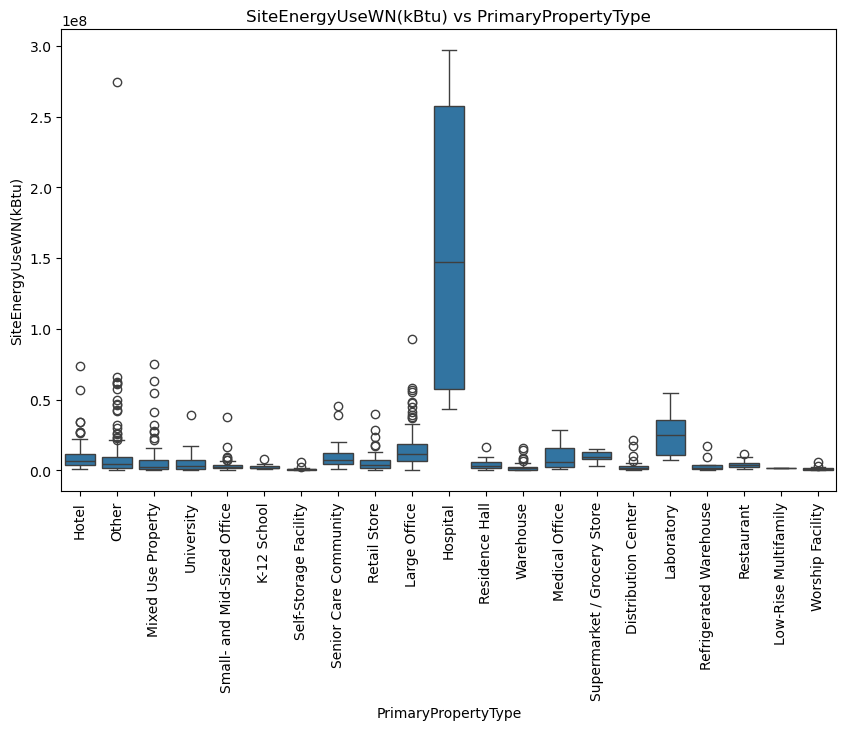

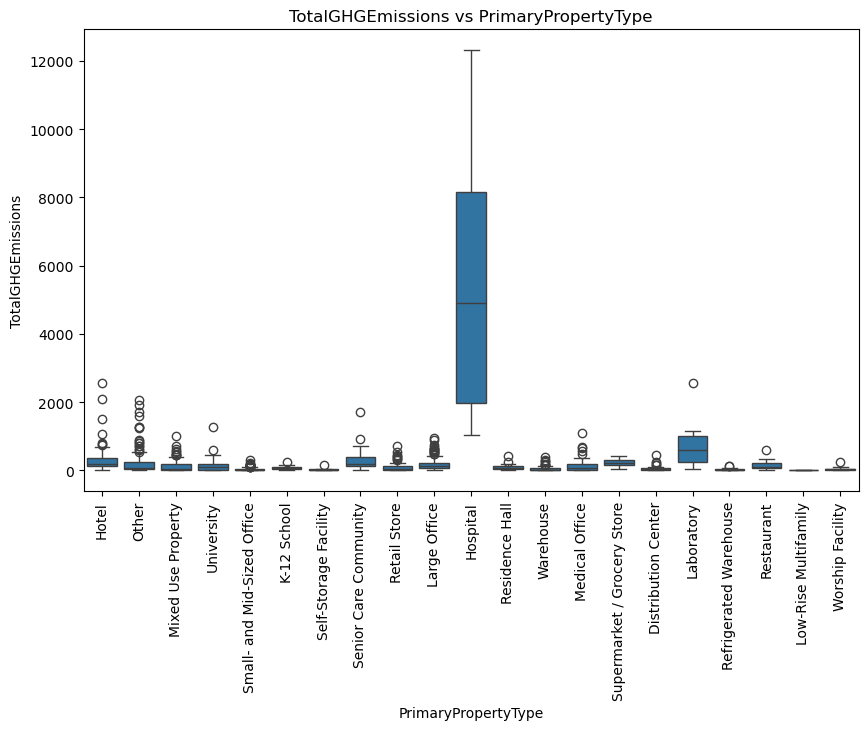

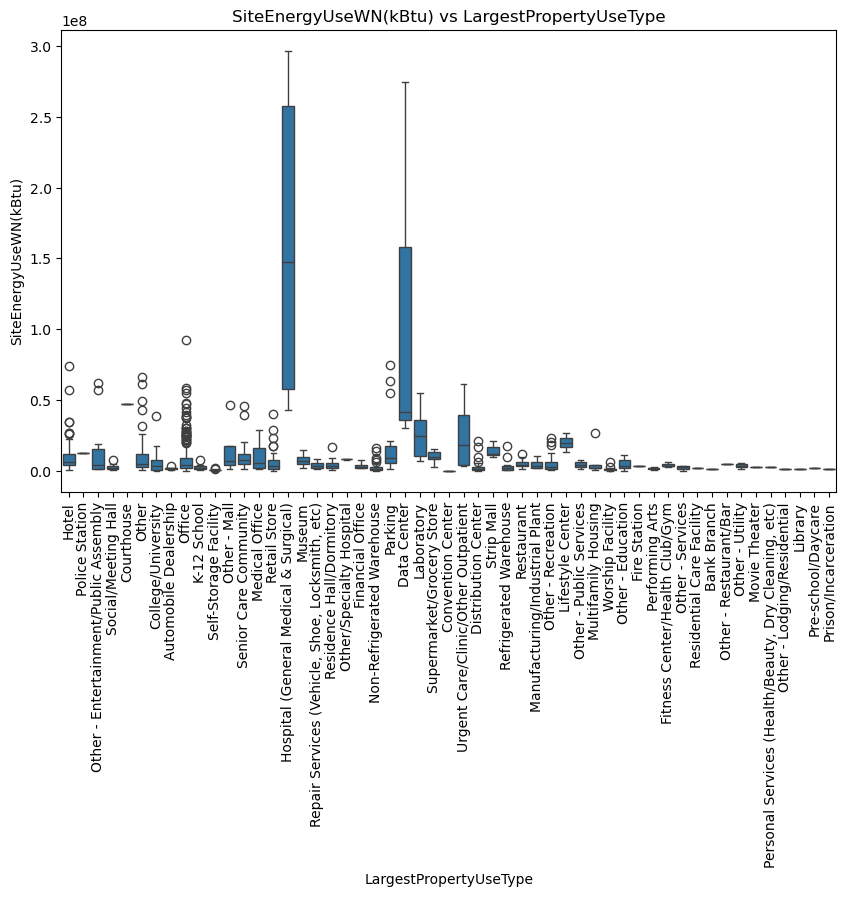

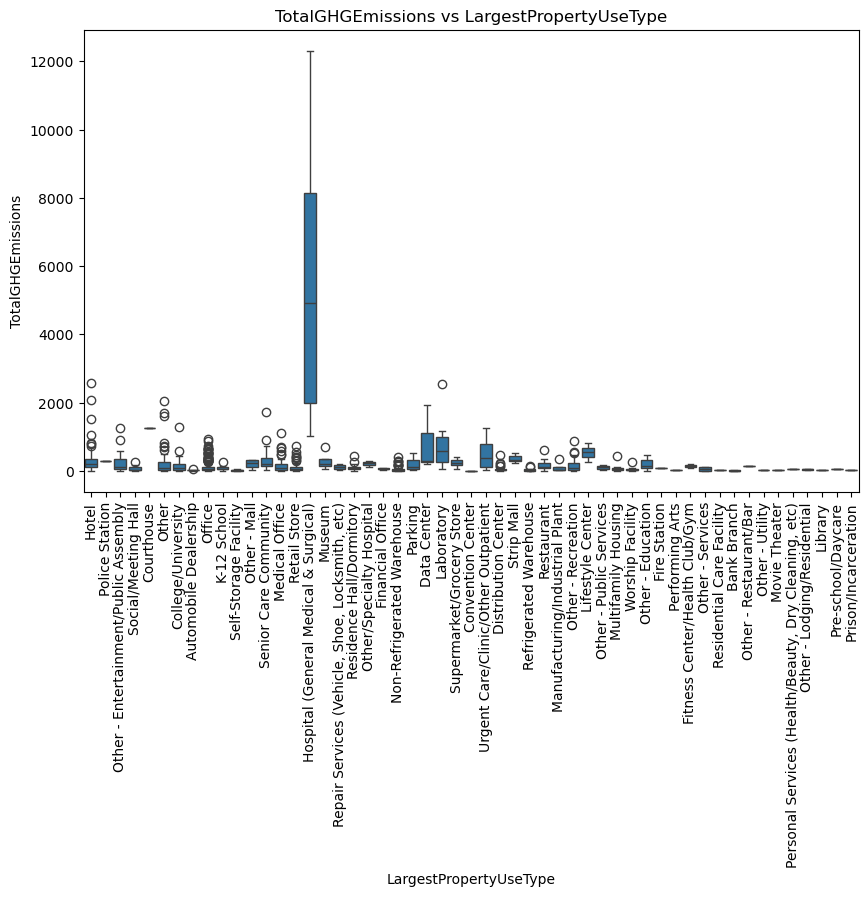

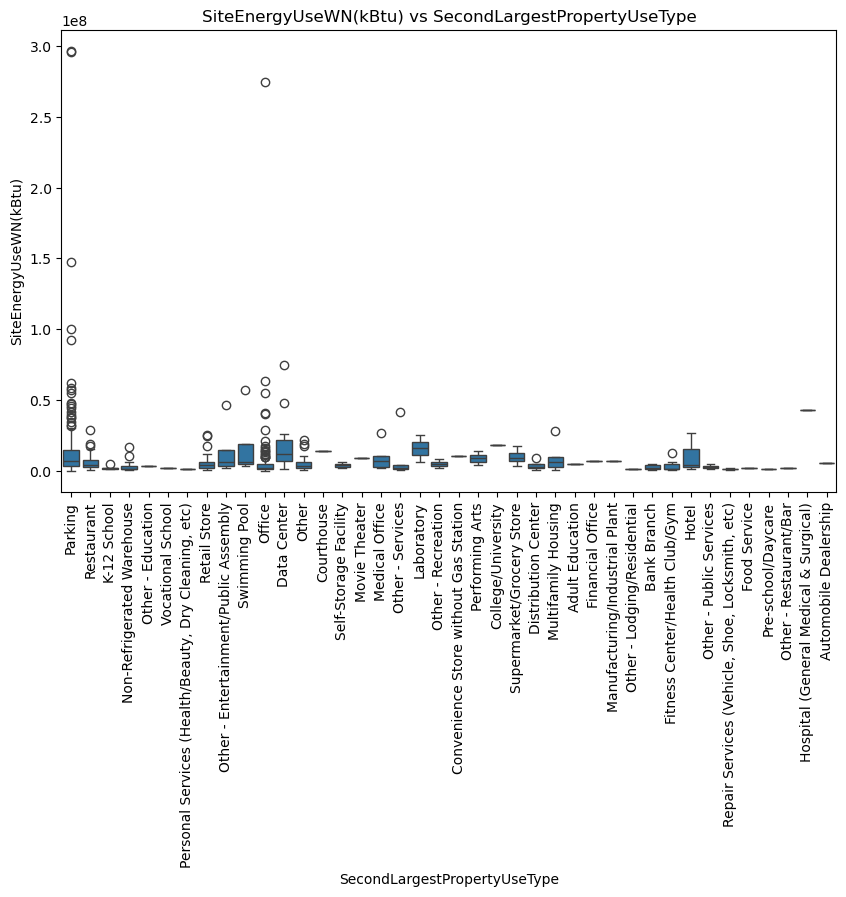

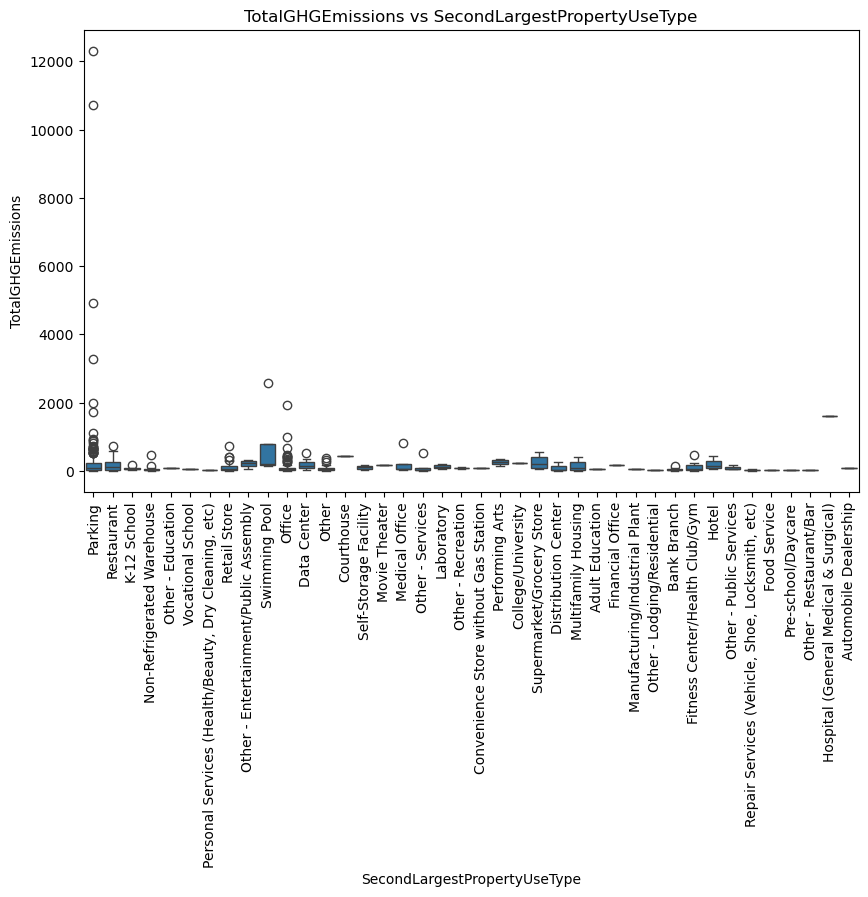

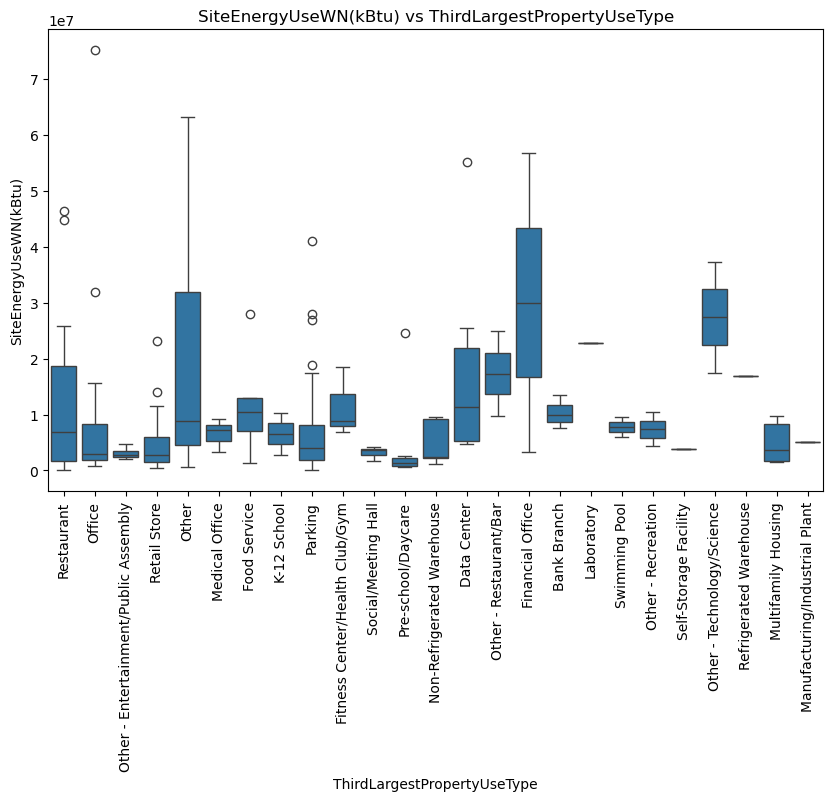

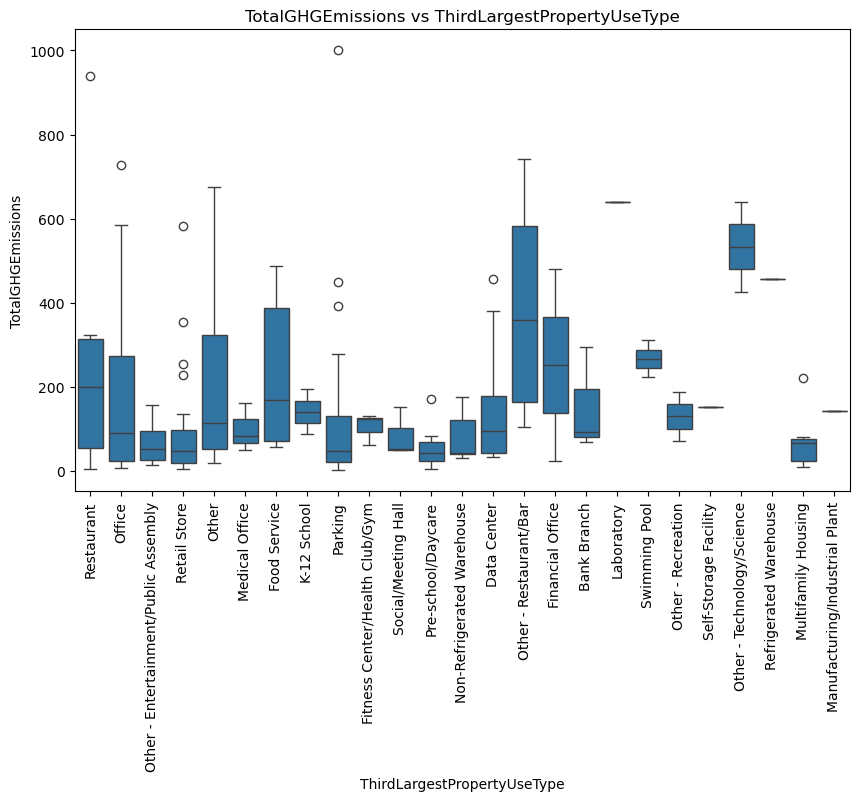

In [108]:
# Etudes des relation entre mes variables catégorielle et mes cibles
for col in df_seattle.select_dtypes(include='object'):
    for target in ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=col, y=target, data=df_seattle)
        plt.xticks(rotation=90)  # Faire pivoter les labels pour une meilleure lisibilité
        plt.title(f"{target} vs {col}")
        # plt.savefig(target +'.png', dpi=300, bbox_inches='tight') si nous voulons enregistrer la figure
        plt.show()

**Analyse Variables / Variables**

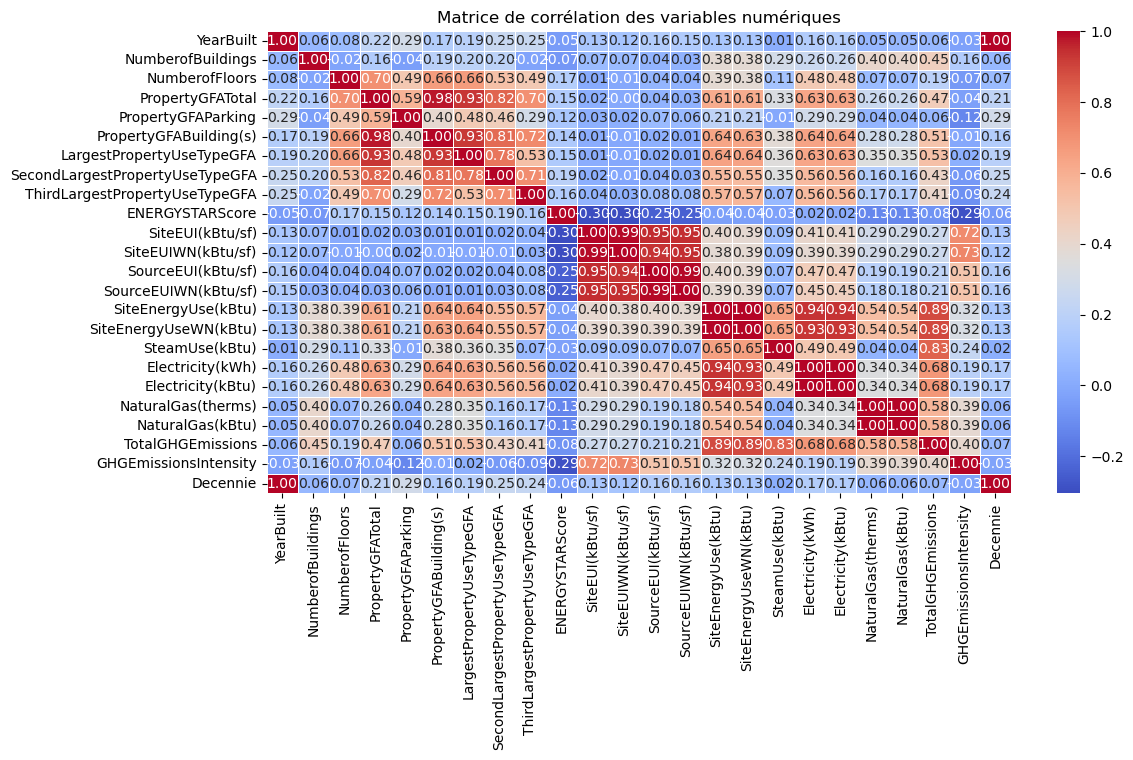

In [111]:
# On récupère uniquement les colonnes numériques
num_var = df_seattle.select_dtypes(include=[np.number])

# On calcule la matrice de corrélation
corr = num_var.corr()

# On trace le heatmap
plt.figure(figsize = (12,6))
sns.heatmap(corr, annot = True,fmt='.2f', linewidths = .5, cmap='coolwarm')
plt.title("Matrice de corrélation des variables numériques")
plt.show()

In [112]:
# faisons un test ANOVA entre nos variables catégorielle et nos cibles
# on récupère toutes les colonnes non numériques
cat_vars = df_seattle.select_dtypes(exclude=[np.number]).columns

for var in num_var:
    for cat_var in cat_vars:
        # retirons les lignes où la variable numérique ou catégorielle est manquante
        df_filt = df_seattle.dropna(subset=[cat_var, var])
        
        # groupons par modalité de la variable catégorielle
        groups = [
            grp[var].values
            for _, grp in df_filt.groupby(cat_var)
            if len(grp[var].dropna()) > 0
        ]
        
        # exécution de l'ANOVA
        anova_result = f_oneway(*groups)
        
        # affichons les résultats
        title = f"{var} vs {cat_var}"
        if anova_result.pvalue > 0.05:
            print(f"{title} -> pas d'effet significatif "
                  f"(F={anova_result.statistic:.2f}, p={anova_result.pvalue:.6f})")
        else:
            print(f"{title} -> effet significatif "
                  f"(F={anova_result.statistic:.2f}, p={anova_result.pvalue:.6f})")
    
    print('=' * 80)

YearBuilt vs PrimaryPropertyType -> effet significatif (F=4.37, p=0.000000)
YearBuilt vs LargestPropertyUseType -> effet significatif (F=2.50, p=0.000000)
YearBuilt vs SecondLargestPropertyUseType -> effet significatif (F=6.93, p=0.000000)
YearBuilt vs ThirdLargestPropertyUseType -> effet significatif (F=1.75, p=0.022900)
NumberofBuildings vs PrimaryPropertyType -> effet significatif (F=17.72, p=0.000000)
NumberofBuildings vs LargestPropertyUseType -> effet significatif (F=10.02, p=0.000000)
NumberofBuildings vs SecondLargestPropertyUseType -> pas d'effet significatif (F=1.07, p=0.363788)
NumberofBuildings vs ThirdLargestPropertyUseType -> pas d'effet significatif (F=0.20, p=0.999984)
NumberofFloors vs PrimaryPropertyType -> effet significatif (F=23.22, p=0.000000)
NumberofFloors vs LargestPropertyUseType -> effet significatif (F=4.20, p=0.000000)
NumberofFloors vs SecondLargestPropertyUseType -> effet significatif (F=1.67, p=0.008002)
NumberofFloors vs ThirdLargestPropertyUseType -> e

Suite à l’analyse ANOVA :

**Ce que j’ai observé :**
- `PrimaryPropertyType` a un effet significatif sur :
  - la consommation énergétique (`SiteEnergyUseWN`)
  - les émissions de GES (`TotalGHGEmissions`)
  - l’année de construction (`YearBuilt`)
  - le score ENERGY STAR (`ENERGYSTARScore`)
- `LargestPropertyUseType` montre aussi des différences significatives.
- En revanche, les usages secondaires (`SecondLargestPropertyUseType`, etc.) n’ont pas montré d’effet significatif.

**Variables à **garder** (significatives) :**
- `PrimaryPropertyType` → variable la plus explicative
- `LargestPropertyUseType` → effet significatif, complémentaire
- `ENERGYSTARScore` → corrélé à la performance énergétique

**Variables à **supprimer** (peu explicatives ou redondantes) :**
- `SecondLargestPropertyUseType`
- `ThirdLargestPropertyUseType`

Ces choix permettent de **réduire la dimensionnalité** tout en conservant l’information utile pour la modélisation.

In [116]:
# Suite a l'annova et l'étude de corrélation
var_2delete = [
    'SiteEnergyUse(kBtu)',   # Cibles et fuites de données
    'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
    'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)',
    'NaturalGas(therms)', 'NaturalGas(kBtu)',
    'PropertyGFABuilding(s)', 'PropertyGFAParking', # PropertyGFATotal = PropertyGFABuildings + PropertyGFAParking
    'GHGEmissionsIntensity',   # Potentiellement redondante avec `TotalGHGEmissions`
    'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
    'PropertyGFATotal',	#très corrélée avec  PropertyGFATotal -> redondance
    'Decennie'
]
df_seattle = df_seattle.drop(columns= var_2delete, axis = 1)
df_seattle.shape

(1083, 9)

In [118]:
fill_rate(df_seattle)

,% de remplissage,Nombre de NaN
PrimaryPropertyType,100.0,0
YearBuilt,100.0,0
NumberofBuildings,100.0,0
NumberofFloors,100.0,0
SiteEnergyUseWN(kBtu),100.0,0
TotalGHGEmissions,100.0,0
LargestPropertyUseType,99.7,3
LargestPropertyUseTypeGFA,99.7,3
ENERGYSTARScore,66.3,365


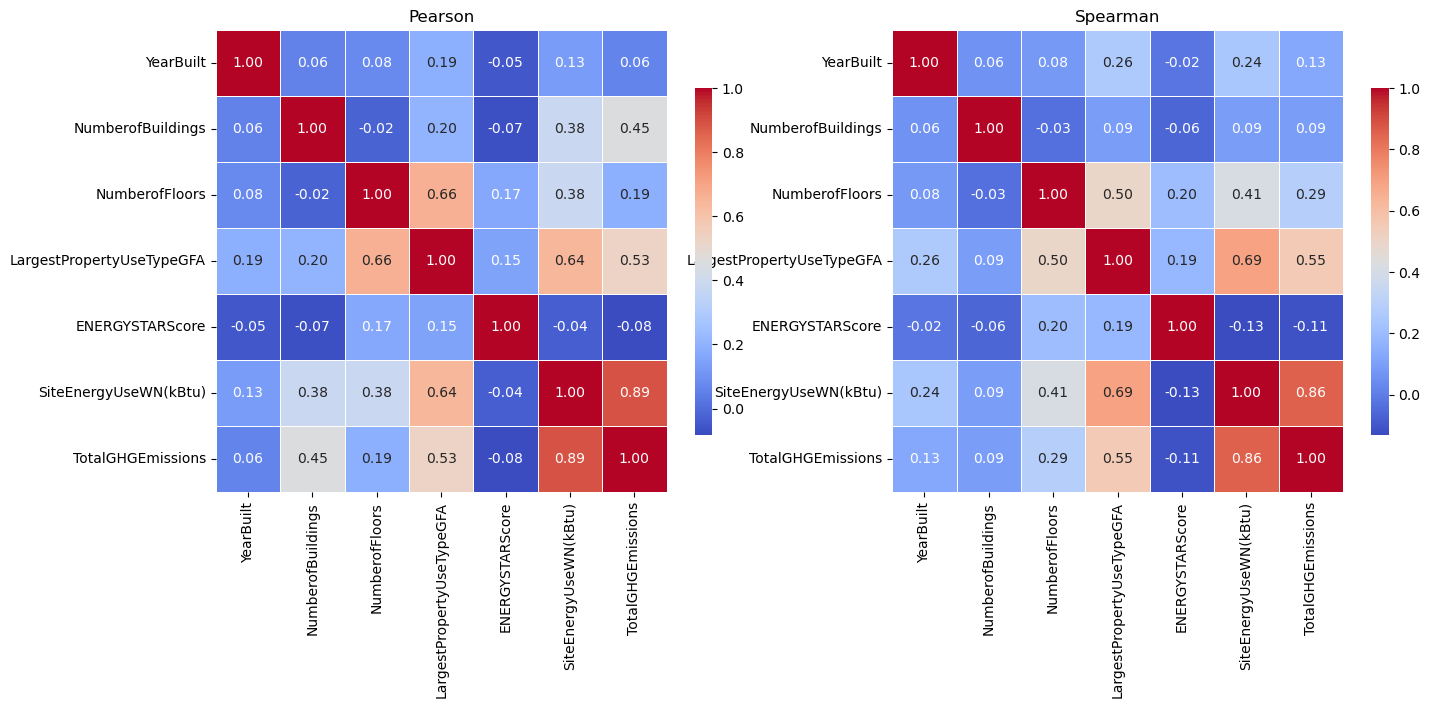

In [120]:
# On récupère uniquement les colonnes numériques
num_var = df_seattle.select_dtypes(include=[np.number]).columns

# On calcule la matrice de corrélation
corr_pearson = df_seattle[num_var].corr(method='pearson') # Matrice de corrélation de Pearson
corr_spearman = df_seattle[num_var].corr(method='spearman') # Matrice de corrélation de Spearman

# On trace les heatmaps
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.heatmap(corr_pearson,ax=axes[0],annot=True,fmt='.2f',linewidths=0.5,cmap='coolwarm',cbar_kws={'shrink': 0.75}) # Heatmap Pearson à gauche
axes[0].set_title("Pearson")

sns.heatmap(corr_spearman,ax=axes[1],annot=True,fmt='.2f',linewidths=0.5,cmap='coolwarm',cbar_kws={'shrink': 0.75})# Heatmap Spearman à droite
axes[1].set_title("Spearman")
plt.show()

In [122]:
for col in df_seattle.select_dtypes(exclude=np.number):
    print(f'Les diffirents catégories dans ma variable {col} sont :')
    print(f'{df_seattle[col].value_counts()}\n')
    print('='*100)

Les diffirents catégories dans ma variable PrimaryPropertyType sont :
PrimaryPropertyType
Small- and Mid-Sized Office    202
Other                          180
Large Office                   130
Warehouse                      114
Retail Store                    66
Mixed Use Property              62
Hotel                           60
Worship Facility                40
Supermarket / Grocery Store     35
Distribution Center             35
Medical Office                  33
K-12 School                     24
Senior Care Community           19
University                      17
Self-Storage Facility           16
Residence Hall                  14
Refrigerated Warehouse          10
Restaurant                       9
Hospital                         9
Laboratory                       7
Low-Rise Multifamily             1
Name: count, dtype: int64

Les diffirents catégories dans ma variable LargestPropertyUseType sont :
LargestPropertyUseType
Office                                              

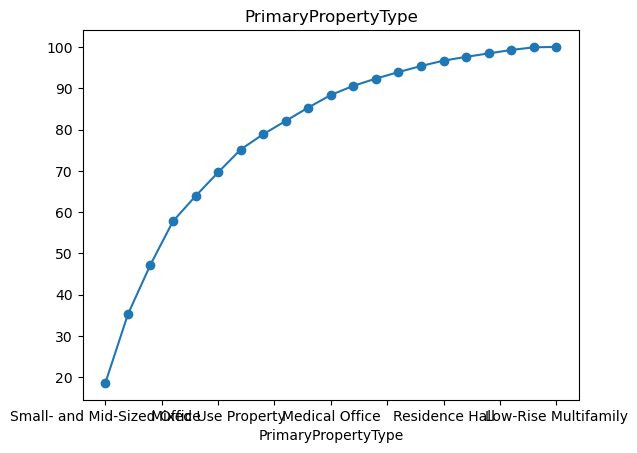

=== 'PrimaryPropertyType' : coude à l’index 6, couvre 75.2% des données



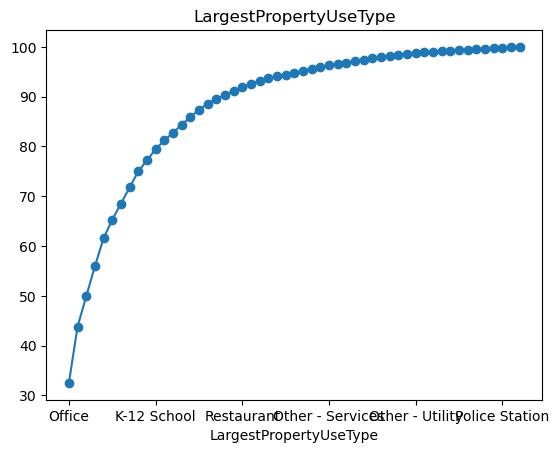

=== 'LargestPropertyUseType' : coude à l’index 15, couvre 87.3% des données



In [124]:
# Calculons les effectifs et pourcentages pour Repérez l’inflexion (« elbow ») dans la courbe cumulée :
#là où l’ajout de nouvelles catégories n’augmente presque plus la couverture.
def find_elbow_threshold(series, coverage='cumul_pc'):
    counts = series.value_counts()
    dist   = pd.DataFrame({
        'count': counts,
        'pc': counts.div(counts.sum())*100
    }).assign(cumul_pc=lambda df: df['pc'].cumsum())
    
    # Visualisation
    dist['cumul_pc'].plot(marker='o')
    plt.title(series.name)
    plt.show()
    
    # Détection du coude automatique a traver KneedLocator
    kl = KneeLocator(
        range(len(dist)), dist['cumul_pc'],
        curve='concave', direction='increasing'
    )
    return dist, kl.knee


for var in df_seattle.select_dtypes(exclude=[np.number]):
    dist, elbow = find_elbow_threshold(df_seattle[var])
    print(f"=== '{var}' : coude à l’index {elbow}, couvre {dist['cumul_pc'].iloc[elbow]:.1f}% des données")
    print('=='*70, '\n')
    index = elbow  # issu de la fonction précédente
    tokeep = dist.index[:index+1]        # modalités conservées
    rares = dist.index[index+1:]        # modalités à regrouper
    df_seattle[var] = df_seattle[var].replace(rares, 'Other')

* **Nettoyage des variables catégorielles par méthode du coude (Elbow Method) :** Réduire le nombre de modalités dans les variables catégorielles tout en conservant la majorité de l'information. Pour cela, on applique la méthode du **coude** sur la courbe de couverture cumulée des catégories.

---

* **Méthode du coude :**
    1. On calcule la fréquence (`count`) de chaque catégorie.
    2. On transforme ces fréquences en pourcentages (`pc`) puis en **cumul de pourcentages** (`cumul_pc`).
    3. On identifie le **point optimal (le coude)** à l’aide de l’algorithme `KneeLocator`.
    4. Les modalités après ce point sont considérées comme **rares** et regroupées dans la catégorie `'Other'`.

---

* **Résultat de l’analyse**

| Variable                  | Index du coude | Couverture cumulée | Action                                      |
|--------------------------|----------------|---------------------|---------------------------------------------|
| `PrimaryPropertyType`    | 6              | 75.2 %              | Regrouper les modalités après le rang 6     |
| `LargestPropertyUseType` | 15             | 87.3 %              | Regrouper les modalités après le rang 15    |

---

* **Conclusion**

La méthode permet de :
- Réduire la complexité du dataset (moins de catégories à gérer).
- Préserver plus de **75 % à 87 %** de l’information initiale.
- Préparer le dataset à l’apprentissage supervisé en **minimisant le bruit** causé par les modalités rares.

Les catégories les moins fréquentes ont été remplacées par `'Other'`, ce qui rend les variables plus robustes pour les algorithmes d’apprentissage.

* Puisque notre étude porte uniquement sur les bâtiments non résidentiels, il faut retirer la ligne correspondant à « Low-Rise Multifamily »

In [130]:
for col in df_seattle.select_dtypes(exclude=np.number):
    print(f'Les diffirents catégories dans ma variable {col} sont :')
    print(f'{df_seattle[col].value_counts()}\n')
    print('='*100)

Les diffirents catégories dans ma variable PrimaryPropertyType sont :
PrimaryPropertyType
Other                          447
Small- and Mid-Sized Office    201
Large Office                   130
Warehouse                      114
Retail Store                    66
Mixed Use Property              62
Hotel                           60
Name: count, dtype: int64

Les diffirents catégories dans ma variable LargestPropertyUseType sont :
LargestPropertyUseType
Office                                   351
Other                                    202
Non-Refrigerated Warehouse               122
Retail Store                              66
Hotel                                     61
Worship Facility                          40
Medical Office                            35
Supermarket/Grocery Store                 35
Distribution Center                       35
K-12 School                               24
Other - Recreation                        24
Senior Care Community                     19
Ot

In [128]:
# Suppression de la catégorie indésirable
df_seattle = df_seattle[df_seattle['PrimaryPropertyType'] != 'Low-Rise Multifamily']

# Suppression des trois lignes qui sont NaN pour nos variables suivantes
df_seattle = df_seattle.dropna(subset=['LargestPropertyUseType', 'LargestPropertyUseTypeGFA'])
print(df_seattle.shape)

(1080, 9)


In [132]:
# Enregistrons nos données
df_seattle.to_csv('ville_de_seattle.csv', index=False)